<div>
  <img style="float: left;"  width="140" src=" 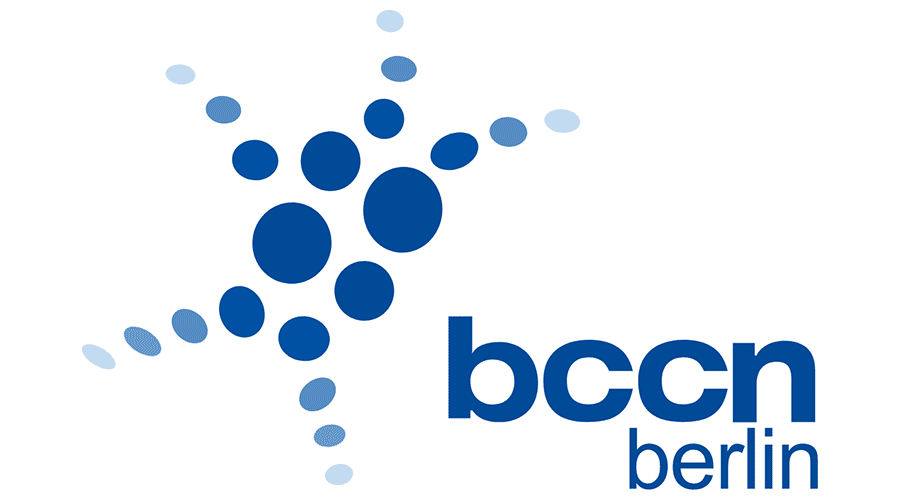">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Computational Modeling Practical Course
        <br>
    </div>
</h1>

<div style="text-align: left; float: left">
    Bernstein Center for Computational Neuroscience Berlin
    <br>Lecturer: Prof. Dr. Henning Sprekeler
    <br>Tutor: Simone Ciceri
</div>

<br>
<h1>
<br>
<br>Final Project
</h1>

<div style="text-align: left">
    Gerardo Parra
</div>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from models import *
from utils import *
from plots import *

ImportError: cannot import name 'f_T' from partially initialized module 'models' (most likely due to a circular import) (/Users/gerardo/Documents/BCCN/Computational Modeling/human_energy_dynamics/models.py)

In [3]:
# Universal variables
METHOD  = 'RK45' #'RK23' #'DOP853' #'LSODA' #'Radau' #'BDF'
T0      = 24.5
TAU_T   = 24

# Simulation parameters 
y0 = [T0]
t_span = (0, 12*24)
t_eval = np.arange(t_span[0], t_span[1], 0.05)
days   = np.arange(t_span[0], t_span[1]+1, 24)

## Introduction
Reports of mental disorders that interfere with focus and task execution, such as major deppressive disorder and attention deficit hyperactivity disorder, have been increasing for several years **(cite)**. Moreover, sociological trends such as growing proportions of young people who identify as introverted and spread of concepts like "bed rotting" point towards a population increasingly struggling with motivation and energy. While the underlying causes are undoubtedly numerous and difficult to disentangle, a mathematical model of the phenomenologically experience of motivation and energy could provide a framework for assessing important factors. I created a **n-dimensional** system to study the dynamics of motivation and energy in response to personal decisions and environmental influences, such as food, sleep and circadian rhythms, mental and physical activity

The physiological and psychological processes underlying these two variables are complex and high dimensional: it is not possible to capture all relevant parts in a simple, interpretable model and particualrly within the scope of this project. Moreover, the goal of this project is primarily the application of the mathematical repertoire we developed in class, not scientific accuracy. I therefore emphasize that while I conducted some superficial reserach to inform the development of this model, the model is partly formed by intuition and is not rigorously scientifically based.

## Methods
First I define some basic terminology and distinguish certain similar concepts.

I then state my assumptions and conventions.

### 1. Circadian rhythm
I begin by modeling the human circadian rhythm. The circadian rhythm is an automatic internal clock regulating alertness which is highly sensitive to light input. The circadian rhythm has an intrinsic period slightly greater than 24 hours long (24.18 hours), but resets its phase in response to light input. Given the relation of this internal clock to the sensation of alertness and drowsiness, we begin by modeling this system.
\begin{align}
C(t) &= \frac{1 - \text{cos}\left(\frac{2\pi}{T}t\right)}{2} \\
\frac{dT}{dt} &= -\text{tanh}\left(T-\mu_T\right)  - \alpha_Lf_L\left(L,\phi\right) \\ %\text{exp}\left(-\frac{\left(T-\mu_T\right)^2}{2\sigma_T^2}\right)
f_L(L,\phi) &= \text{PRC}\left(\phi\right)L \\
\text{PRC}\left(\phi\right) &= \text{exp}\left(-\frac{\left(\phi-\frac{\pi}{2}\right)^2}{\pi^2/8}\right)-\text{exp}\left(-\frac{\left(\phi-2\pi\right)^2}{\pi^2/8}\right)
\end{align}

where $C$ is a variable representing one's circadian rhythm, $T$ is the variable whose dynamics we model representing the period of the circadian rhythm, and $\phi$ is the phase of the sinusoidal function, namely $\phi\left(t,T\right) = 2\pi \lfloor{\frac{t}{T}}\rfloor$. PRC represents the phase response curve, which defines the impact of an input (light in this case) on the phase of the circadian rhythm depending on the phase of the rhythm at the time it is received. This function was designed to resemble PRCs as documented in the circadian rhythm literature (**CITE**) and was constructed by summing two exponentials, a positive one centered at $\frac{\pi}{2}$ to create the phase advancing effect of light received during one's morning, and a negative one centered at $2\pi$ to represent the phase delay caused by light during one's night. The parameters and intial conditions were manually chosen to create realistic dynamics, namely $\mu_T=24.5, \tau_T=24, \alpha_L=2$, and $T_0=24.5$.

### 2. Sleep
We next model sleep and its interactions with the circadian rhythm. Sleep 
\begin{align}
\frac{dS}{dt} = \frac{1-S}{\tau_S} - \frac{R}{\tau_R}
\end{align}



# Code

## 1. Circadian rhythm

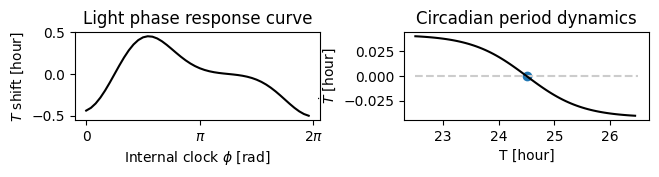

In [3]:
# Plot system components
fig, ax = plt.subplots(1, 2, figsize=(7,2))
fig.tight_layout(pad=3)
# Plot phase response curve
day = np.arange(0, 24, 0.5)
ax[0].plot(phi(day,24), PRC(phi(day,24)), 'k')
ax[0].set_xlabel(r'Internal clock $\phi$ [rad]'), ax[0].set_ylabel(r'$T$ shift [hour]')
ax[0].set_xticks([0,np.pi,2*np.pi],['0',r'$\pi$',r'$2\pi$'])
ax[0].set_title('Light phase response curve')

# Plot dT(T)
T = np.arange(T0-2,T0+2,0.05)
ax[1].hlines(0, T0-2, T0+2, '#ccc', '--')
ax[1].plot(T, dT(T, mu=T0, tau=TAU_T), 'k'), ax[1].scatter(T0,0)
ax[1].set_xlabel('T [hour]'), ax[1].set_ylabel(r'$\dot{T}$ [hour]')
ax[1].set_title('Circadian period dynamics')
plt.show()

NameError: name 'f_T' is not defined

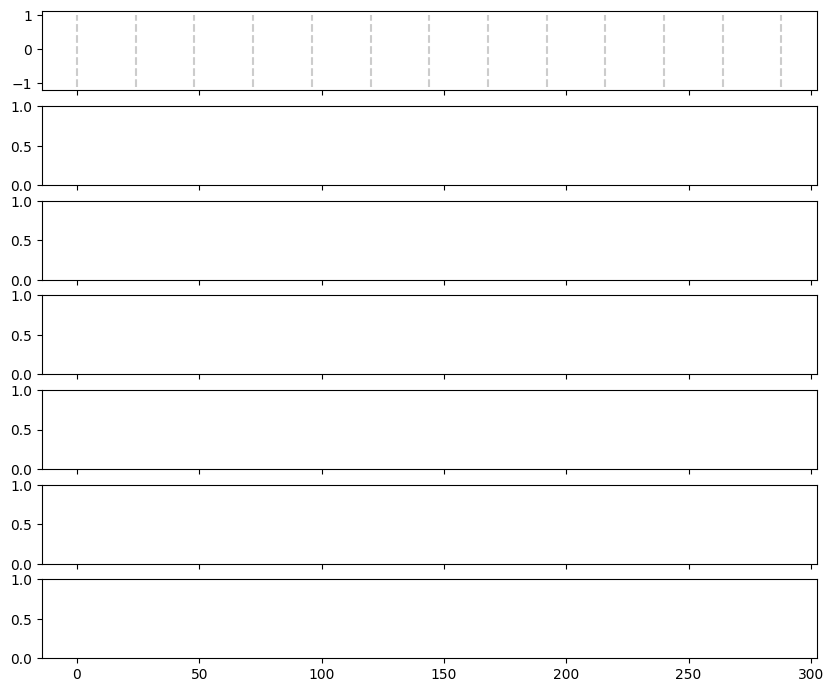

In [4]:
params_circadian = {
    'alpha': 3,
    'mu': T0,
    'tau': TAU_T
}
conditions_circadian = {
    'No light input':     {'hours': [], 'amp': 1, 'L': input_daily},
    'Day - optimal':      {'center': 12.5, 'amp': 0.5, 'width': 3, 'L': input_daily_smooth},
    'Day - modern':       {'hours': [(7,8),(12,13),(18,19),(21,22.5)], 'amp': [0.5, 0.75, 0.2, 0.1], 'L': input_daily},
    'Winter':             {'hours': [(8,9),(12,13),(18,22.5)], 'amp': [0.25, 0.25, 0.1], 'L': input_daily},
    'Winter - SAD lamp':  {'hours': [(7.5,8),(8,9),(12,13),(18,22.5)], 'amp': [0.75,0.25, 0.25, 0.1], 'L': input_daily},
    'Night - excessive':  {'hours': [(18,0),(0,6)], 'amp': 1, 'L': input_daily},
    'Day - excessive':    {'hours': [(6,18)], 'amp': 1, 'L': input_daily},
}
n_cond = len(conditions_circadian)

## Solve and plot solutions
fig, ax = plt.subplots(n_cond, 1, figsize=(10, 1.2*n_cond), sharex=True) 
solutions = []
for i, cond in enumerate(conditions_circadian.keys()):
    # Solve
    params_i = params_circadian
    params_i['light'] = conditions_circadian[cond]
    solutions.append(solve_ivp(circadian, t_span, y0, args=(params_i,), t_eval=t_eval, method=METHOD, rtol=1e-8, atol=1e-10))
    # Plot
    plot_days(days, ax[i])
    plot_circadian(solutions[i], ax=ax[i])
    ax[i].plot(solutions[i].t, params_i['light']['L'](solutions[i].t, params_i['light']) - 1.1, label="Light Input", color="orange")
    ax[i].set_title(cond)
    ax[i].set_yticks([0, 1])
ax[0].legend(['24 hour periods',"Circadian Rhythm", "Light Input"], loc="upper left", bbox_to_anchor=(1.05, 1))
plt.xlabel('Time [days]'), set_day_xticks(t_span)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

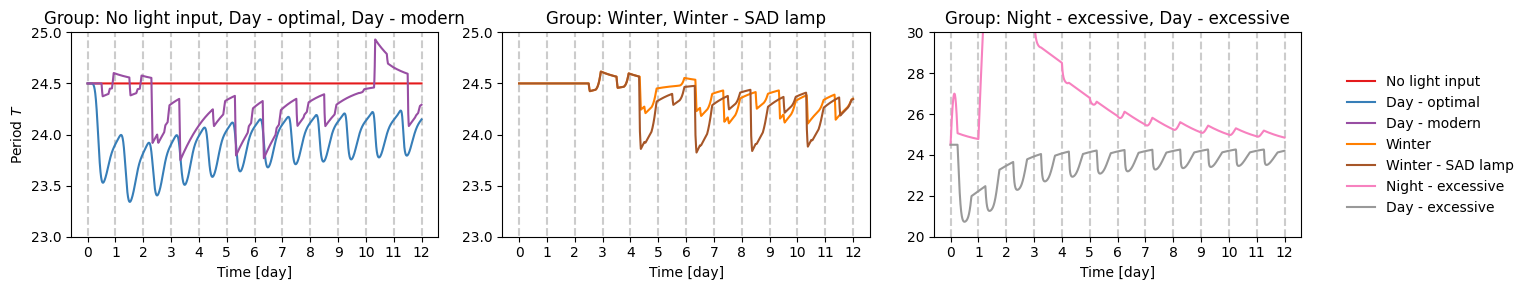

In [5]:
# Define condition groups
condition_names = list(conditions_circadian.keys())
group1 = condition_names[:3]
group2 = condition_names[3:5]
group3 = condition_names[5:]
colors = plt.get_cmap('Set1', len(condition_names))
groups = [group1, group2, group3]

# Loop over each subplot group
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, group in zip(axes, groups):
    plot_days(days, amp=(20, 30), ax=ax)
    for cond in group:
        idx = condition_names.index(cond)
        ax.plot(solutions[idx].t, solutions[idx].y[0], label=cond, color=colors(idx))
    ax.set_xlabel('Time [day]')
    set_day_xticks(t_span, ax=ax)
    ax.set_ylim(23, 25)
    ax.set_title(f'Group: {", ".join(group)}')
axes[0].set_ylabel(r'Period $T$')
axes[-1].set_ylim(20,30)

# Single unified legend
handles = [plt.Line2D([], [], color=colors(i), label=name) for i, name in enumerate(condition_names)]
fig.legend(handles, condition_names, loc="center right", bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

## 2. Sleep

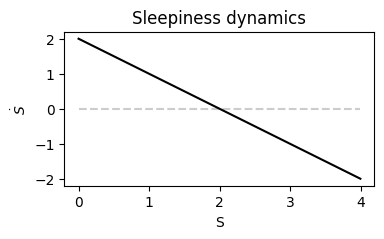

In [55]:
# Plot Sleepiness dynamics
plt.figure(figsize=(4,2))
S_states = np.arange(0, 4, 0.01)
plt.hlines(0, 0, S_states[-1], '#ccc', '--')
plt.plot(S_states, dS(S_states, 1), 'k')
plt.xlabel('S'), plt.ylabel(r'$\dot{S}$')
plt.title('Sleepiness dynamics')

plt.show()

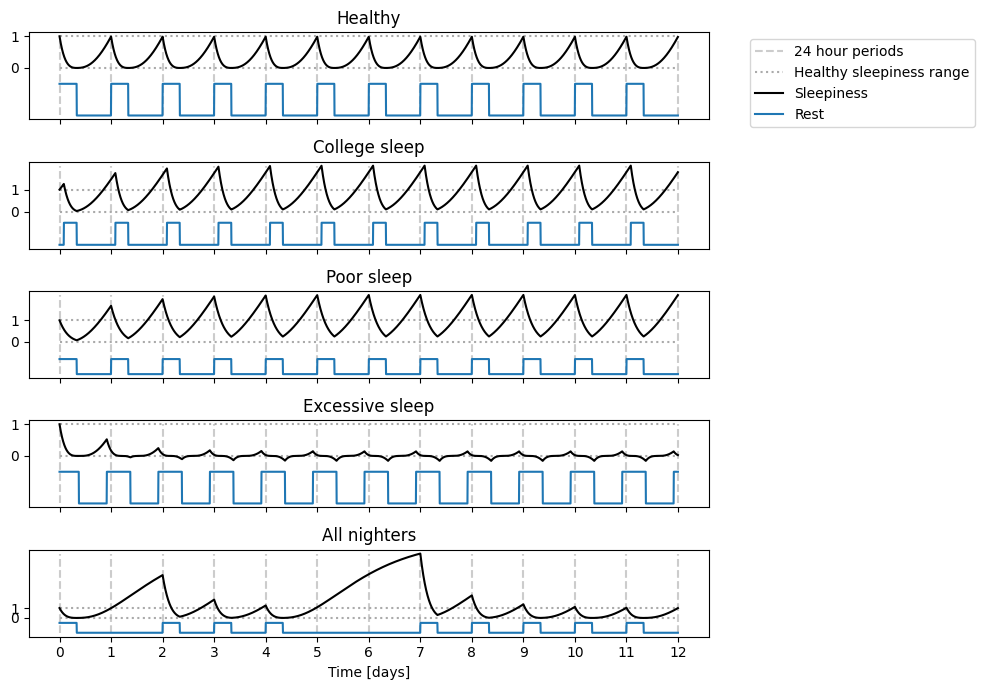

In [56]:
params_sleep = {
    'S0':    [1],
    'tau_S': 24,
    'tau_R': 5.5,
}
conditions_sleep = {
    'Healthy': {'hours': [(0,8)], 'amp': 1, 'R': input_daily},
    'College sleep': {'hours': [(2,8)], 'amp': 1, 'R': input_daily},
    'Poor sleep': {'hours': [(0,8)], 'amp': 0.7, 'R': input_daily},
    'Excessive sleep': {'hours': [(22,24),(0,9)], 'amp': [1,1], 'R': input_daily},
    'All nighters': {'hours': [[(0,8)],[],[(0,8)],[(0,8)],[(0,8)],[],[],[(0,8)],[(0,8)],[(0,8)],[(0,8)],[(0,8)]], 'amp': [[1] for _ in range(12)], 'R': input_variable}
}
n_cond = len(conditions_sleep.keys())

## Solve and plot sleep solutions
fig, ax = plt.subplots(n_cond, 1, figsize=(10, 1.4*n_cond), sharex=True)
solutions = []
for i, cond in enumerate(conditions_sleep.keys()):
    # Solve
    params_i = params_sleep
    params_i['rest'] = conditions_sleep[cond]
    solutions.append(solve_ivp(sleep, t_span, params_sleep['S0'], args=(params_i,), t_eval=t_eval, rtol=1e-8, atol=1e-10))
    # Plot
    plot_days(days, ax[i], amp=(-1.5, solutions[i].y[0].max()**3))
    ax[i].hlines([0,1], 0, t_span[-1], '#aaa', ':')
    ax[i].plot(solutions[i].t, f_S(solutions[i].y[0]), 'k', label='Sleepiness')
    ax[i].plot(solutions[i].t, params_i['rest']['R'](solutions[i].t, params_i['rest']) - 1.5, label="Rest")
    ax[i].set_title(cond)
    ax[i].set_yticks([0, 1])
ax[0].legend(['24 hour periods','Healthy sleepiness range','Sleepiness','Rest'], loc="upper left", bbox_to_anchor=(1.05, 1))
ax[-1].set_xlabel('Time [days]'), set_day_xticks(t_span)
fig.tight_layout()
plt.show()

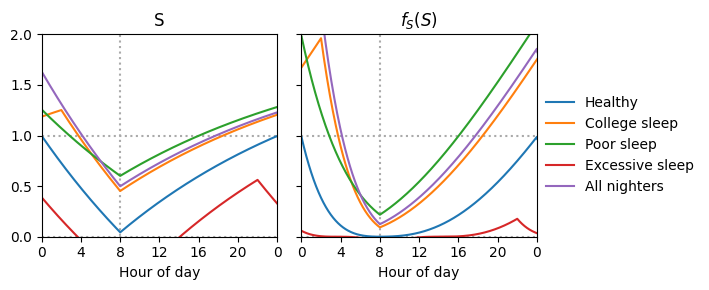

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# Define x-limits and compute custom x-ticks and labels
xlims = (48, 72)
xticks = np.arange(xlims[0], xlims[1]+1, 4)  # every 4 hours
xtick_labels = [str(int(t % 24)) for t in xticks]

# Color cycle so both plots use the same colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# --- Left subplot ---
axes[0].hlines([0, 1], *xlims, color='#aaa', linestyles=':')
axes[0].vlines([56], -1, 2, color='#aaa', linestyles=':')
for i, cond in enumerate(conditions_sleep.keys()):
    axes[0].plot(solutions[i].t, solutions[i].y[0], label=cond, color=colors[i])
axes[0].set_xlim(*xlims)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xtick_labels)
axes[0].set_title("S")
axes[0].set_xlabel("Hour of day")

# --- Right subplot ---
axes[1].hlines([0, 1], *xlims, color='#aaa', linestyles=':')
axes[1].vlines([56], -1, 2, color='#aaa', linestyles=':')
for i, cond in enumerate(conditions_sleep.keys()):
    axes[1].plot(solutions[i].t, f_S(solutions[i].y[0]), label=cond, color=colors[i])
axes[1].set_xlim(*xlims)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xtick_labels)
axes[1].set_ylim(0, 2)
axes[1].set_title(r'$f_S(S)$')
axes[1].set_xlabel("Hour of day")

# Single legend outside
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space on right for legend
plt.show()


## 3. Combine model components

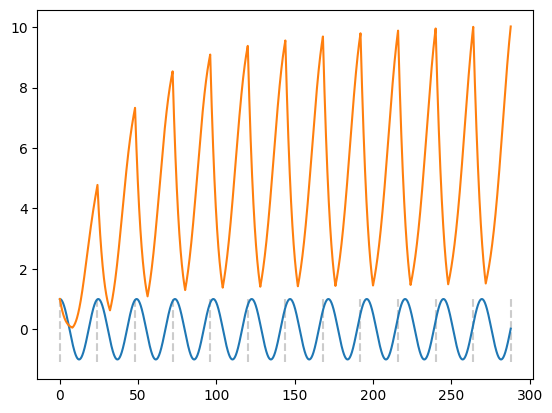

In [4]:
def energy(t, y, params, A_T=0.5):
    T    = y[0]
    S    = y[1]
    # Circadian dynamics
    L    = params['C']['light']['L'](t, params['C']['light'])
    dTdt =  dT(T, mu=params['C']['mu'], tau=params['C']['tau']) - params['C']['alpha'] * f_L(phi(t,T=T), L)
    # Sleep dynamics
    R = params['S']['rest']['R']
    dSdt = ( dS(S, params['S']['tau_S']) - R(t, params['S']['rest'])/params['S']['tau_R'] ) + A_T*(2 - f_T(T,t))/params['C']['tau']
    return [dTdt, dSdt]

params_energy = {
    'C': {
        'alpha': 3,
        'mu': T0,
        'tau': TAU_T,
        'light': {'hours': [], 'amp': 1, 'L': input_daily}
    },
    'S': {
        'tau_S': 24,
        'tau_R': 6,
        'rest': {'hours': [(0,8)], 'amp': 1, 'R': input_daily},
    }
}

y0  = [T0, 1]
sol = solve_ivp(energy, t_span, y0, t_eval=t_eval, args=(params_energy,), rtol=1e-8, atol=1e-10)

plot_days(days)
plt.plot(sol.t, f_T(sol.y[0], sol.t))
# plt.plot(solutions[0].t, f_S(solutions[0].y[0]))
plt.plot(sol.t, f_S(sol.y[1]))
# plt.plot(sol.t, params_energy['S']['rest']['R'](sol.t, params_energy['S']['rest']) - 1.5)
# plt.xlim(200,300)
plt.show()